# Treinamento de uma CNN no CIFAR 10

In [101]:
nome = 'Mateus Oliveira da Silva'

print(f'Meu nome é {nome}')

Meu nome é Mateus Oliveira da Silva


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [102]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [103]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [104]:
batch_size = 50

## Download do CIFAR-10

In [105]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Criação do dataloader

In [106]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [107]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

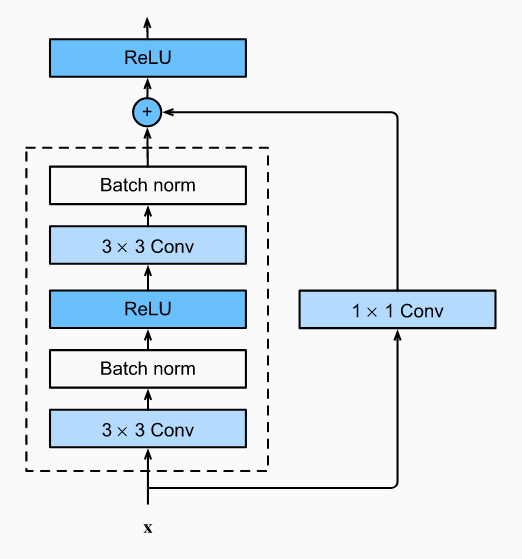

In [108]:
from torch import nn
from torch import Tensor


class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        # the variable names is important for receive data on dict
        self.conv1 = nn.Conv2d(inplanes, planes, 3, stride, padding=(1,1), groups=1, bias=False, dilation=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, padding=(1,1), groups=1, bias=False, dilation=1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = nn.Conv2d(inplanes, planes, 1, stride, padding=0, groups=1, bias=False, dilation=1)


    def forward(self, x: Tensor) -> Tensor:
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out = out + self.downsample(x)

        out = self.relu(out)
        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [109]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [110]:
class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()

        self.block1 = MyBasicBlock(inplanes=3, planes=64, stride=stride)
        self.block2 = MyBasicBlock(inplanes=64, planes=64, stride=stride)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.linear_classifier = nn.Linear(64, 10)        

    def forward(self, x):

        x = self.block1(x)        
        x = self.block2(x)
        x = self.pooling(x).squeeze()
        x = self.linear_classifier(x)

        return x


## Treinamento

### Definição dos hiperparâmetros

In [111]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [113]:
def evaluation(model, loader):

    with torch.no_grad():

        total = 0
        acertos = 0
        for x, y in loader:
            y_hat = model(x.to(device))
            y_hat = torch.argmax(y_hat, dim=1)

            y = y.to(device) 
            y_hat = y_hat.to(device)

            acertos += y[y == y_hat].shape[0]
            total += 1 * x.shape[0]

        mean_accuracy = acertos / total
        
        print(f'Accuracy: {mean_accuracy}')

### Laço de treinamento

In [114]:
from tqdm import tqdm


model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Accuracy: 0.1023


Training: 100%|██████████| 800/800 [00:28<00:00, 28.28it/s]


Epoch: 0/19 Loss: 1.703018307685852
Accuracy: 0.4083


Training: 100%|██████████| 800/800 [00:27<00:00, 29.20it/s]


Epoch: 1/19 Loss: 1.2633333206176758
Accuracy: 0.4715


Training: 100%|██████████| 800/800 [00:27<00:00, 29.29it/s]


Epoch: 2/19 Loss: 1.389955997467041
Accuracy: 0.519


Training: 100%|██████████| 800/800 [00:27<00:00, 29.29it/s]


Epoch: 3/19 Loss: 1.2498290538787842
Accuracy: 0.5457


Training: 100%|██████████| 800/800 [00:27<00:00, 29.33it/s]


Epoch: 4/19 Loss: 1.2240532636642456
Accuracy: 0.571


Training: 100%|██████████| 800/800 [00:26<00:00, 29.63it/s]


Epoch: 5/19 Loss: 1.3894505500793457
Accuracy: 0.603


Training: 100%|██████████| 800/800 [00:27<00:00, 29.61it/s]


Epoch: 6/19 Loss: 1.2438985109329224
Accuracy: 0.6104


Training: 100%|██████████| 800/800 [00:27<00:00, 29.26it/s]


Epoch: 7/19 Loss: 1.2298500537872314
Accuracy: 0.6221


Training: 100%|██████████| 800/800 [00:27<00:00, 29.32it/s]


Epoch: 8/19 Loss: 0.9958492517471313
Accuracy: 0.6369


Training: 100%|██████████| 800/800 [00:27<00:00, 29.26it/s]


Epoch: 9/19 Loss: 0.8685625195503235
Accuracy: 0.6345


Training: 100%|██████████| 800/800 [00:27<00:00, 29.28it/s]


Epoch: 10/19 Loss: 0.8334100842475891
Accuracy: 0.6552


Training: 100%|██████████| 800/800 [00:27<00:00, 29.12it/s]


Epoch: 11/19 Loss: 0.8471241593360901
Accuracy: 0.6661


Training: 100%|██████████| 800/800 [00:27<00:00, 29.36it/s]


Epoch: 12/19 Loss: 0.8393431901931763
Accuracy: 0.6684


Training: 100%|██████████| 800/800 [00:27<00:00, 29.42it/s]


Epoch: 13/19 Loss: 0.6819171905517578
Accuracy: 0.6738


Training: 100%|██████████| 800/800 [00:27<00:00, 29.40it/s]


Epoch: 14/19 Loss: 1.0791020393371582
Accuracy: 0.6723


Training: 100%|██████████| 800/800 [00:27<00:00, 29.23it/s]


Epoch: 15/19 Loss: 0.8229310512542725
Accuracy: 0.686


Training: 100%|██████████| 800/800 [00:27<00:00, 29.40it/s]


Epoch: 16/19 Loss: 0.629788875579834
Accuracy: 0.6921


Training: 100%|██████████| 800/800 [00:27<00:00, 29.13it/s]


Epoch: 17/19 Loss: 0.7206219434738159
Accuracy: 0.6909


Training: 100%|██████████| 800/800 [00:27<00:00, 29.18it/s]


Epoch: 18/19 Loss: 0.6418635845184326
Accuracy: 0.6992


Training: 100%|██████████| 800/800 [00:27<00:00, 29.34it/s]


Epoch: 19/19 Loss: 0.6459334492683411
Accuracy: 0.7024


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

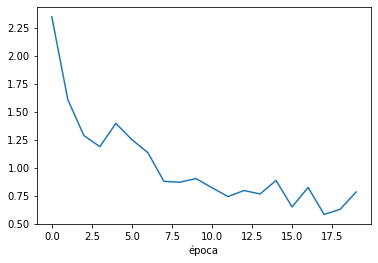

In [115]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [116]:
evaluation(model=model, loader=test_dataloader)

Accuracy: 0.7036


# Bonus Opcional

## Implementando o Dropout

In [117]:
class MyDropout(nn.Module):
    def __init__(self, p: float = 0.5):
        super(MyDropout, self).__init__()
        
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, " "but got {}".format(p))
        self.p = p

    def __call__(self, x, training = True):
        if training:
            #https://pytorch.org/docs/stable/generated/torch.nn.functional.dropout.html
            bernoulli = torch.distributions.bernoulli.Bernoulli(probs=(self.p))
            return x * bernoulli.sample(x.size()) * (self.p)# generate matrix zeros and ones.

        else:
            return x

In [118]:

# x = torch.rand(16, 3, 32, 32)

p = 0.3

# bernoulli = torch.distributions.bernoulli.Bernoulli(probs=(p))

# #bernoulli.sample(x.size())
# x * bernoulli.sample(x.size()
torch.distributions.bernoulli.Bernoulli(probs=(p))


Bernoulli(probs: 0.30000001192092896)

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [119]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)

mean zeros: 0.4996744692325592
mean zeros pytorch: 0.4980265200138092
